The purpose of this script is to demonstrate the use of the Tensor Flow Library
to implement a simple neural network.
 
While other methods such as regression or SVM's are likely to perfom better on a dataset of this variety, I am interested here in comparing my results with the ones discussed in this paper:

http://lab.fs.uni-lj.si/lasin/wp/IMIT_files/neural/doc/seminar8.pdf

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image
from pandas import get_dummies
from sklearn.cross_validation import train_test_split
# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data = pd.read_csv('../input/Iris.csv', index_col = 0)

In [3]:
data.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
data.shape

(150, 5)

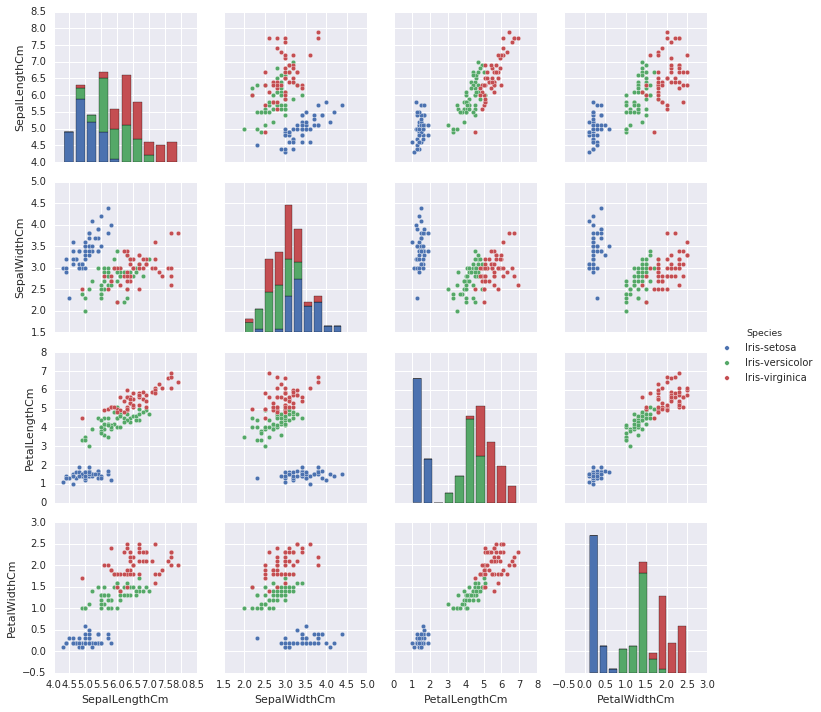

In [5]:
# Visualize data with Seaborn
g=sns.pairplot(data, hue="Species", size= 2.5)

In [6]:
cols = data.columns
features = cols[0:4]
labels = cols[4]
print(features)
print(labels)

Index(['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'], dtype='object')
Species


In [7]:
#Well conditioned data will have zero mean and equal variance
#We get this automattically when we calculate the Z Scores for the data

data_norm = pd.DataFrame(data)

for feature in features:
    data[feature] = (data[feature] - data[feature].mean())/data[feature].std()

#Show that should now have zero mean
print("Averages")
print(data.mean())

print("\n Deviations")
#Show that we have equal variance
print(pow(data.std(),2))

Averages
SepalLengthCm   -1.457168e-15
SepalWidthCm    -1.722511e-15
PetalLengthCm   -2.043551e-15
PetalWidthCm    -9.843977e-17
dtype: float64

 Deviations
SepalLengthCm    1.0
SepalWidthCm     1.0
PetalLengthCm    1.0
PetalWidthCm     1.0
dtype: float64


In [8]:
#Shuffle The data
indices = data_norm.index.tolist()
indices = np.array(indices)
np.random.shuffle(indices)
X = data_norm.reindex(indices)[features]
y = data_norm.reindex(indices)[labels]

In [9]:
# One Hot Encode as a dataframe
y = get_dummies(y)

# Generate Training and Validation Sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3)

# Convert to np arrays so that we can use with TensorFlow
X_train = np.array(X_train).astype(np.float32)
X_test  = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_test  = np.array(y_test).astype(np.float32)

In [10]:
#Check to make sure split still has 4 features and 3 labels
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(105, 4) (105, 3)
(45, 4) (45, 3)


In [11]:
training_size = X_train.shape[1]
test_size = X_test.shape[1]
num_features = 4
num_labels = 3


num_hidden = 10

graph = tf.Graph()
with graph.as_default():
    tf_train_set    = tf.constant(X_train)
    tf_train_labels = tf.constant(y_train)
    tf_valid_set    = tf.constant(X_test)
 
    
    print(tf_train_set)
    print(tf_train_labels)
    
    ## Note, since there is only 1 layer there are actually no hidden layers... but if there were
    ## there would be num_hidden
    weights_1 = tf.Variable(tf.truncated_normal([num_features, num_hidden]))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden, num_labels]))
    ## tf.zeros Automaticaly adjusts rows to input data batch size
    bias_1 = tf.Variable(tf.zeros([num_hidden]))
    bias_2 = tf.Variable(tf.zeros([num_labels]))
    
    
    logits_1 = tf.matmul(tf_train_set , weights_1 ) + bias_1
    rel_1 = tf.nn.relu(logits_1)
    logits_2 = tf.matmul(rel_1, weights_2) + bias_2
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits_2, tf_train_labels))
    optimizer = tf.train.GradientDescentOptimizer(.005).minimize(loss)
    
    
    ## Training prediction
    predict_train = tf.nn.softmax(logits_2)
    
    
    
    # Validation prediction
    logits_1_val = tf.matmul(tf_valid_set, weights_1) + bias_1
    rel_1_val    = tf.nn.relu(logits_1_val)
    logits_2_val = tf.matmul(rel_1_val, weights_2) + bias_2
    predict_valid = tf.nn.softmax(logits_2_val)

Tensor("Const:0", shape=(105, 4), dtype=float32)
Tensor("Const_1:0", shape=(105, 3), dtype=float32)


In [12]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

num_steps = 10000
with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    print(loss.eval())
    for step in range(num_steps):
        _,l, predictions = session.run([optimizer, loss, predict_train])
        
        if (step % 2000 == 0):
              #print(predictions[3:6])
              print('Loss at step %d: %f' % (step, l))
              print('Training accuracy: %.1f%%' % accuracy( predictions, y_train[:, :]))
              print('Validation accuracy: %.1f%%' % accuracy(predict_valid.eval(), y_test))
        

2.37078
Loss at step 0: 2.370779
Training accuracy: 21.0%
Validation accuracy: 22.2%
Loss at step 2000: 0.158171
Training accuracy: 98.1%
Validation accuracy: 97.8%
Loss at step 4000: 0.092324
Training accuracy: 96.2%
Validation accuracy: 97.8%
Loss at step 6000: 0.074089
Training accuracy: 96.2%
Validation accuracy: 97.8%
Loss at step 8000: 0.065289
Training accuracy: 97.1%
Validation accuracy: 97.8%


In [13]:
# Conclusion - Despite poor performance of the model, I was pleased to see the 
# accuaracy for the training and validation set appears to match closely with
# the values quoted for the probabalistic neural network studied in the paper.